In [ ]:
import re, json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from hanspell import spell_checker
from pykospacing import Spacing
from tqdm import tqdm, notebook
%matplotlib inline

In [ ]:
from konlpy.tag import Mecab

In [ ]:
train_data = pd.read_table('ratings_train.txt',sep="\t")
test_data = pd.read_table('ratings_test.txt',sep='\t')

In [ ]:
DATA_IN_PATH = './clean_data/'

## NAN 값 제거

In [ ]:
train_data.isna().sum()

id          0
document    5
label       0
dtype: int64

In [ ]:
train_data.dropna(axis=0,inplace=True)
train_data.reset_index(inplace=True)

In [ ]:
train_data

,index,id,document,label
0,0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0
3,3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...,...
149990,149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149991,149996,8549745,평점이 너무 낮아서...,1
149992,149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149993,149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
train_data.isna().sum()

index       0
id          0
document    0
label       0
dtype: int64

In [ ]:
test_data.isna().sum()

id          0
document    3
label       0
dtype: int64

In [ ]:
test_data.dropna(axis=0,inplace=True)
test_data.reset_index(inplace=True)
test_data.isna().sum()

index       0
id          0
document    0
label       0
dtype: int64

# 데이터 분석

C:\ProgramData\Anaconda3\envs\python3.7env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

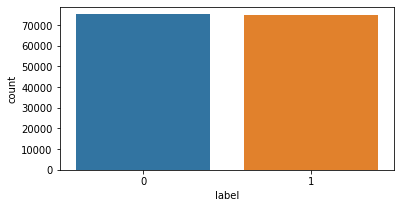

In [ ]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6,3)
sns.countplot(train_data['label'])

In [ ]:
print("긍정 리뷰 수: ",train_data['label'].value_counts()[1])
print("부정 리뷰 수: ",train_data['label'].value_counts()[0])

긍정 리뷰 수:  74825
부정 리뷰 수:  75170


# 특수문자 제거

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
clean_train_df=train_data
clean_test_df=test_data
clean_train_df

C:\ProgramData\Anaconda3\envs\python3.7env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\python3.7env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,id,document,label
0,0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0
3,3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...,...
149990,149995,6222902,인간이 문제지 소는 뭔죄인가,0
149991,149996,8549745,평점이 너무 낮아서,1
149992,149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149993,149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


### 특수문자 제거 후 빈 리뷰 데이터 삭제 과정

In [ ]:
clean_train_df['document'] = clean_train_df['document'].str.replace('^ +',"")
clean_train_df['document'].replace('',np.nan, inplace=True)
print(clean_train_df.isnull().sum())
print(clean_train_df.loc[clean_train_df.document.isnull()][:10]) # nan 값 확인가능

C:\ProgramData\Anaconda3\envs\python3.7env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


index          0
id             0
document    1255
label          0
dtype: int64
      index        id document  label
404     404   4221289      NaN      0
412     412   9509970      NaN      1
470     470  10147571      NaN      1
584     584   7117896      NaN      0
593     593   6478189      NaN      0
638     638   9364602      NaN      0
668     668   1600635      NaN      0
1058   1058   5890638      NaN      0
1312   1312   5831045      NaN      0
1549   1549   7246718      NaN      1


In [ ]:
print("처리 전:",len(clean_train_df))
clean_train_df = clean_train_df.dropna(how='any')
print("처리 후:",len(clean_train_df))
clean_train_review = clean_train_df.document.tolist()

처리 전: 149995
처리 후: 148740


In [ ]:
clean_test_df['document'] = clean_test_df['document'].str.replace('^ +',"")
clean_test_df['document'].replace('',np.nan, inplace=True)
print(clean_test_df.isnull().sum())
print(clean_test_df.loc[clean_test_df.document.isnull()][:10]) # nan 값 확인가능
print("처리 전:",len(clean_test_df))
clean_test_df = clean_test_df.dropna(how='any')
print("처리 후:",len(clean_test_df))
clean_test_review = clean_test_df.document.tolist()

index         0
id            0
document    422
label         0
dtype: int64
     index       id document  label
1        1  9274899      NaN      0
116    116  6910486      NaN      1
254    254  4976468      NaN      0
468    468  7517102      NaN      0
504    504  2096424      NaN      0
558    558   171480      NaN      1
712    712  7545542      NaN      0
743    743  8845712      NaN      0
814    814  7170767      NaN      1
857    857  2084375      NaN      0
처리 전: 49997
처리 후: 49575


C:\ProgramData\Anaconda3\envs\python3.7env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
# label data 정리
y_train = np.array(clean_train_df['label'])
y_test = np.array(clean_test_df['label'])
print(len(y_train))
print(len(y_test))

148740
49575


### kospacing example

In [ ]:
spacing = Spacing()
kospacing_sent = spacing(clean_train_review[0])
kospacing_sent

'아 더빙 진짜 짜증나네요 목소리'

In [ ]:
without_space = clean_train_review[0].replace(" ",'')
kospacing_sent = spacing(without_space)
kospacing_sent

'아더빙진짜 짜증나네 요목소리'

#### 물론 고유명사가 띄어지는 문제점은 여전히 발생함

In [ ]:
clena_train_review

['아 더빙 진짜 짜증나네요 목소리',
 '흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 솔직히 재미는 없다평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움',
 '원작의 긴장감을 제대로 살려내지못했다',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫겟다 납치감금만반복반복이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나',
 '걍인피니트가짱이다진짜짱이다',
 '볼때마다 눈물나서 죽겠다년대의 향수자극허진호는 감성절제멜로의 달인이다',
 '울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해',
 '담백하고 깔끔해서 좋다 신문기사로만 보다 보면 자꾸 잊어버린다 그들도 사람이었다는 것을',
 '취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어거지고 감동도 어거지',
 'ㄱ냥 매번 긴장되고 재밋음ㅠㅠ',
 '참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다그냥 까고싶어서 안달난것처럼 보인다',
 '굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐',
 '이건 정말 깨알 캐스팅과 질퍽하지않은 산뜻한 내용구성이 잘 버무러진 깨알일드',
 '약탈자를 위한 변명 이라 저놈들은 착한놈들 절대 아닌걸요',
 '나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님',
 '보면서 웃지 않는 건 불가능하다',
 '재미없다 지루하고 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남바베트의 만찬은 이야기도 있고 음식 보는재미도 있는데  이건 볼게없다 음식도 별로 안나오고 핀란드 풍경이라도 구경할랫는데 그것

# kospacing 진행

* 1은 spacing 진행 전 기존 댓글 띄어쓰기 합쳐서 한 후 spacing 진행
* 2는 spacing 진행 시 기존 댓글 그대로 진행

In [ ]:
CLEAN_TRAIN_SPACING = 'clean_train_spacing.npy'
CLEAN_TRAIN_SPACING2 = 'clean_train_spacing2.npy'
CLEAN_TEST_SPACING = 'clean_test_spacing.npy'
CLEAN_TEST_SPACING2 = 'clean_test_spacing2.npy'

In [ ]:
# spacing 진행 시 기존 댓글 띄어쓰기 합쳐서 한 후 진행한 경우
clean_train_spacing=[]
spacing = Spacing()
for review in notebook.tqdm(clean_train_review):
    if type(review) == str:
        without_space = review.replace(" ",'')
        kospacing_sent = spacing(without_space)
        clean_train_spacing.append(kospacing_sent)
    else:
        clean_train_spacing.append([])

  0%|          | 0/149995 [00:00<?, ?it/s]

In [ ]:
# spacing 진행 시 댓글 그대로 진행한 경우
clean_train_spacing2=[]
spacing = Spacing()
for review in notebook.tqdm(clean_train_review):
    if type(review) == str:
        kospacing_sent = spacing(review)
        clean_train_spacing2.append(kospacing_sent)
    else:
        clean_train_spacing2.append([])

  0%|          | 0/148740 [00:00<?, ?it/s]

In [ ]:
np.save(open(DATA_IN_PATH + CLEAN_TRAIN_SPACING, 'wb'), clean_train_spacing)
np.save(open(DATA_IN_PATH + CLEAN_TRAIN_SPACING2, 'wb'), clean_train_spacing2)

### test data도 kospacing 진행

In [ ]:
# spacing 진행 시 기존 댓글 띄어쓰기 합쳐서 한 후 진행한 경우
clean_test_spacing=[]
spacing = Spacing()
for review in notebook.tqdm(clean_test_review):
    if type(review) == str:
        without_space = review.replace(" ",'')
        kospacing_sent = spacing(without_space)
        clean_test_spacing.append(kospacing_sent)
    else:
        clean_test_spacing.append([])

  0%|          | 0/49575 [00:00<?, ?it/s]

In [ ]:
# spacing 진행 시 댓글 그대로 진행한 경우
clean_test_spacing2=[]
spacing = Spacing()
for review in notebook.tqdm(clean_test_review):
    if type(review) == str:
        kospacing_sent = spacing(review)
        clean_test_spacing2.append(kospacing_sent)
    else:
        clean_test_spacing2.append([])

  0%|          | 0/49575 [00:00<?, ?it/s]

In [ ]:
np.save(open(DATA_IN_PATH + CLEAN_TEST_SPACING, 'wb'), clean_test_spacing)
np.save(open(DATA_IN_PATH + CLEAN_TEST_SPACING2, 'wb'), clean_test_spacing2)

In [ ]:
clean_train_spacing = np.load(open(DATA_IN_PATH + CLEAN_TRAIN_SPACING, 'rb'))
clean_train_spacing2 = np.load(open(DATA_IN_PATH + CLEAN_TRAIN_SPACING2, 'rb'))
clean_test_spacing = np.load(open(DATA_IN_PATH + CLEAN_TEST_SPACING, 'rb'))
clean_test_spacing2 = np.load(open(DATA_IN_PATH + CLEAN_TEST_SPACING2, 'rb'))

## Hanspell spacing2에 적용해보기

In [ ]:
clean_train_spell2=[]
for review in notebook.tqdm(clean_train_spacing2):
    if type(review) == str:
        clean_spell = spell_checker.check(review)
        review_text = clean_spell.checked
        clean_train_spell2.append(review_text)
    else:
        clean_train_spell2.append([])

  0%|          | 0/148740 [00:00<?, ?it/s]

In [ ]:
clean_train_spell2

['아 더빙 진짜 짜증 나네요 목소리',
 '흠포스터 보고 초등학생 영화 줄 오버 연기조차 가볍지 않구나',
 '너무 재밓었다 그래서 보는 것을 추천한다',
 '교도소 이야기구먼 솔직히 재미는 없다 평점 조정',
 '사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커스틴 던스트가 너무나도 이 뻐보였다',
 '막 걸음마 뗀 세부터 초등학교 학년생인 살용 영화ㅋㅋㅋ 별반 개도 아까움',
 '원작의 긴장감을 제대로 살려내지 못했다',
 '별 반 개도 아깝다 욕 나온 다 이 음경 길용우 연기생활이 몇 년인지 정말 발로해도 그것보단 낫겠다 납치 감금만 반복 반복이 드라마는 가족도 없다 연기 못하는 사람만 모였네',
 '액션이 없는데도 재미있는 몇 안 되는 영화',
 '왜 케 평점이 낮은 건데 꽤 볼만한 데 할리우드식 화려함에만 너무 길들여져 있나',
 '그냥 인피니트가 짱이 다 진짜 최고다',
 '볼 때마다 눈물 나서 죽겠다 연대의 향수 자극 허진호는 감성절 제 멜로의 달인이다',
 '울면서 손들고 횡단보도 건널 때 뛰쳐나올 뻔 이 범수 연기 더럽게 못해',
 '담백하고 깔끔해서 좋다 신문 기사로만 보다 보면 자꾸 잊어버린 다 그들도 사람이었다는 것을',
 '취향은 존중한 다지만 진짜 내 생에 극장에서 본 영화 중 가장 나 잼 노 감동임 스토리도 억지고 감동도 억지',
 'ㄱ냥 매번 긴장되고 재밌음ᅲᅲ',
 '참 사람들 웃긴 게 바스코가 이기면 락스 코라고 까고 바비가 이기면 아이돌이라고 깐 다 그냥 까고 싶어서 안 달란 것처럼 보인다',
 '굿바이 레닌 표절인 것은 이해하는데 왜 뒤로 갈수록 재미 없어지냐',
 '이건 정말 깨알 캐스팅과 질퍽하지 않은 산뜻한 내용 구성이 잘 버무려진 깨알 일드',
 '약탈자를 위한 변명이라 저놈들은 착 한 놈들 절대 아닌 걸요',
 '나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님',
 '보면서 웃 지 않는 건 불가능하다',
 '재미없다 지루하고 같은 음식 영화인데도 바베트의 

In [ ]:
CLEAN_TRAIN_SPELL2 = 'clean_train_spell2.npy'
np.save(open(DATA_IN_PATH + CLEAN_TRAIN_SPELL2, 'wb'), clean_train_spell2)

In [ ]:
# 위의 hanspell 적용 데이터는 아직 사용안함

## mecab 적용 및 불용어 처리

In [ ]:
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','흠','아','더']

In [ ]:
def preprocessing(review, mecab, remove_stopwords=False, stop_words = []):
    word_review = mecab.morphs(review)
    
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
    return word_review

In [ ]:
def mecab_preprocessing(clean_spacing):
    clean_mecab=[]
    mecab=Mecab(dicpath='C:/mecab/mecab-ko-dic')
    for review in notebook.tqdm(clean_spacing.tolist()):
        if type(review) == str:
            clean_mecab.append(preprocessing(review, mecab, remove_stopwords = True, stop_words=stop_words))
        else:
            clean_mecab.append([])
    return clean_mecab

In [ ]:
clean_train_mecab = mecab_preprocessing(clean_train_spacing)
clean_train_mecab2 = mecab_preprocessing(clean_train_spacing2)

  0%|          | 0/148740 [00:00<?, ?it/s]

  0%|          | 0/148740 [00:00<?, ?it/s]

In [ ]:
clean_test_mecab = mecab_preprocessing(clean_test_spacing)
clean_test_mecab2 = mecab_preprocessing(clean_test_spacing2)

  0%|          | 0/49575 [00:00<?, ?it/s]

  0%|          | 0/49575 [00:00<?, ?it/s]

## 여기서 train tokenizer 시킬 데이터 설정

In [ ]:
TRAIN_TOKEN = clean_train_mecab
TEST_TOKEN = clean_test_mecab
TRAIN_INPUT_DATA = 'train_mecab.npy'
TRAIN_LABEL_DATA = 'train_mecab_label.npy'
TEST_INPUT_DATA = 'test_mecab.npy'
TEST_LABEL_DATA = 'test_mecab_label.npy'

In [ ]:
print(len(clean_train_mecab))
print(len(y_train))

148740
148740


## tensorflow tokenizer

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(TRAIN_TOKEN)
tokenizer.word_index

{'영화': 1,
 '다': 2,
 '고': 3,
 '하': 4,
 '을': 5,
 '보': 6,
 '게': 7,
 '지': 8,
 '있': 9,
 '없': 10,
 '좋': 11,
 '나': 12,
 '었': 13,
 '만': 14,
 '너무': 15,
 '는데': 16,
 '봤': 17,
 '안': 18,
 '로': 19,
 '적': 20,
 '정말': 21,
 '어': 22,
 '음': 23,
 '것': 24,
 '재밌': 25,
 '지만': 26,
 '네': 27,
 '같': 28,
 '네요': 29,
 '진짜': 30,
 '거': 31,
 '기': 32,
 '했': 33,
 '에서': 34,
 '않': 35,
 '았': 36,
 '인': 37,
 '수': 38,
 '되': 39,
 '면': 40,
 'ㅋㅋ': 41,
 '말': 42,
 '점': 43,
 '연기': 44,
 '최고': 45,
 '던': 46,
 '내': 47,
 '주': 48,
 '평점': 49,
 '이런': 50,
 '해': 51,
 '할': 52,
 '왜': 53,
 '어요': 54,
 '겠': 55,
 'ㅋㅋㅋ': 56,
 '스토리': 57,
 '습니다': 58,
 '그': 59,
 '생각': 60,
 '듯': 61,
 '아니': 62,
 '드라마': 63,
 '싶': 64,
 '사람': 65,
 '때': 66,
 '감동': 67,
 '본': 68,
 '배우': 69,
 '함': 70,
 '보다': 71,
 '까지': 72,
 '라': 73,
 '뭐': 74,
 '알': 75,
 '볼': 76,
 '만들': 77,
 '내용': 78,
 '감독': 79,
 '그냥': 80,
 '재미있': 81,
 '중': 82,
 '재미': 83,
 '시간': 84,
 '지루': 85,
 '요': 86,
 '잼': 87,
 '였': 88,
 '서': 89,
 '사랑': 90,
 '니': 91,
 '쓰레기': 92,
 '재미없': 93,
 '못': 94,
 '냐': 95,
 '번': 96,
 '년':

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 49696
등장 빈도가 2번 이하인 희귀 단어의 수: 28080
단어 집합에서 희귀 단어의 비율: 56.50354153251771
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7288469201874272


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print(vocab_size)
tokenizer = Tokenizer(num_words=vocab_size) 
tokenizer.fit_on_texts(TRAIN_TOKEN)
X_train = tokenizer.texts_to_sequences(TRAIN_TOKEN)
X_test = tokenizer.texts_to_sequences(TEST_TOKEN)

21617


In [ ]:
len(tokenizer.word_index) # 결과가 겉으로 보기에는 vocab size 만큼 적용이 안된것 같지만 tokenizer 내부에서는 적용된 것임

49696

### 빈도수 낮은 단어만 구성되었던 리뷰들 -> 위의 과정으로 비었으니 삭제

In [ ]:
print("기존 train_data수:",len(X_train))
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
print(len(drop_train))
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

기존 train_data수: 148740
201
148539
148539


리뷰의 최대 길이 : 82
리뷰의 평균 길이 : 13.397801250849945


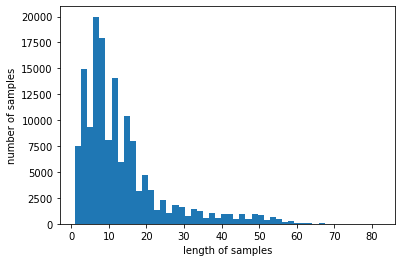

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 50
below_threshold_len(max_len,X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.17017752913377


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), X_train)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), y_train)

In [ ]:
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), X_test)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), y_test)

In [ ]:
X_train = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
y_train = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
X_test = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
y_test = np.load(open(DATA_IN_PATH + TEST_LABEL_DATA, 'rb'))

## 모델 학습

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.models import load_model

### 간단한 LSTM 모델

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./output/best_model_mecab2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1981/1981 [==============================] - 215s 107ms/step - loss: 0.4327 - acc: 0.7956 - val_loss: 0.3447 - val_acc: 0.8479

Epoch 00001: val_acc improved from -inf to 0.84792, saving model to ./output\best_model_mecab2.h5
Epoch 2/15
1981/1981 [==============================] - 228s 115ms/step - loss: 0.3216 - acc: 0.8611 - val_loss: 0.3227 - val_acc: 0.8580

Epoch 00002: val_acc improved from 0.84792 to 0.85798, saving model to ./output\best_model_mecab2.h5
Epoch 3/15
1981/1981 [==============================] - 226s 114ms/step - loss: 0.2948 - acc: 0.8764 - val_loss: 0.3148 - val_acc: 0.8645

Epoch 00003: val_acc improved from 0.85798 to 0.86455, saving model to ./output\best_model_mecab2.h5
Epoch 4/15
1981/1981 [==============================] - 226s 114ms/step - loss: 0.2716 - acc: 0.8873 - val_loss: 0.3149 - val_acc: 0.8669

Epoch 00004: val_acc improved from 0.86455 to 0.86694, saving model to ./output\best_model_mecab2.h5
Epoch 5/15
1981/1981 [=====================

### hanspell(x), spacing: 기존 댓글 띄어쓰기 제거 후 진행

In [ ]:
loaded_model = load_model('best_model_mecab.h5')
print("테스트 정확도: %.4f" %(loaded_model.evaluate(X_test,y_test)[1]))

1550/1550 [==============================] - 23s 14ms/step - loss: 0.3189 - acc: 0.8622
테스트 정확도: 0.8622


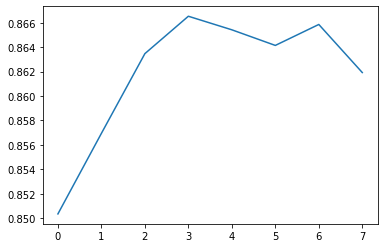

In [ ]:
plt.plot(history.history['val_acc'])

### hanspell(x), spacing: 기존 댓글 띄어쓰기 그대로 진행

In [ ]:
loaded_model = load_model('./output/best_model_mecab2.h5')
print("테스트 정확도: %.4f" %(loaded_model.evaluate(X_test,y_test)[1]))

1550/1550 [==============================] - 22s 14ms/step - loss: 0.3193 - acc: 0.8650
테스트 정확도: 0.8650


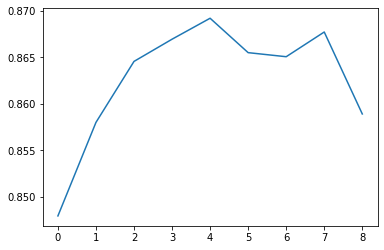

In [ ]:
plt.plot(history.history['val_acc'])

## LSTM 3계층 모델

### hanspell(x), spacing: 기존 댓글 띄어쓰기 제거 후 진행

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 100))
model2.add(Dropout(0.15))
model2.add(LSTM(128,return_sequences=True))
model2.add(LSTM(128,return_sequences=True))
model2.add(LSTM(128))
model2.add(Dropout(0.15))
model2.add(Dense(15, activation='tanh'))
model2.add(Dropout(0.15))
model2.add(Dense(15, activation='tanh'))
model2.add(Dense(1, activation='sigmoid'))  # 지금은 결국 정답 label이 1차원이고 0,1 판단이므로 softmax 못씀 

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./output/best_model2_mecab.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1981/1981 [==============================] - 738s 370ms/step - loss: 0.4454 - acc: 0.7853 - val_loss: 0.3518 - val_acc: 0.8474

Epoch 00001: val_acc improved from -inf to 0.84741, saving model to ./output\best_model2_mecab2.h5
Epoch 2/15
1981/1981 [==============================] - 944s 477ms/step - loss: 0.3276 - acc: 0.8609 - val_loss: 0.3331 - val_acc: 0.8578

Epoch 00002: val_acc improved from 0.84741 to 0.85782, saving model to ./output\best_model2_mecab2.h5
Epoch 3/15
1981/1981 [==============================] - 867s 438ms/step - loss: 0.2971 - acc: 0.8761 - val_loss: 0.3139 - val_acc: 0.8660

Epoch 00003: val_acc improved from 0.85782 to 0.86600, saving model to ./output\best_model2_mecab2.h5
Epoch 4/15
1981/1981 [==============================] - 800s 404ms/step - loss: 0.2773 - acc: 0.8867 - val_loss: 0.3197 - val_acc: 0.8681

Epoch 00004: val_acc improved from 0.86600 to 0.86812, saving model to ./output\best_model2_mecab2.h5
Epoch 5/15
1981/1981 [=================

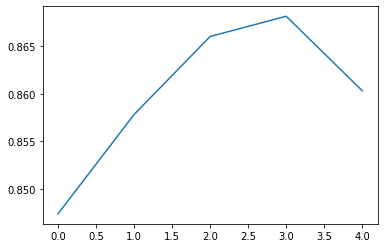

In [ ]:
plt.plot(history.history['val_acc'])

In [ ]:
# 이 위의 모델 훈련 완료되면 해당 모델 파일명을 best_model2_mecab 으로 바꾸기 이거 2 가 아니라 1임 